# Backtesting the "Cramer Effect"

**The cramer-effect/cramer-bounce**: After the show *Mad Money* the recommended stocks are bought by viewers almost immediately (afterhours trading) or on the next day at market open, increasing the price for a short period of time.

**Facts:**
- Mad money is from 6:00 PM to 7:00 PM ET
    - (This is 10:00 PM 11:00 PM UTC+0) 
- NYSE is open from 9:30 AM to 4:00 PM ET
    - (This is 1:30 PM to 8:00 PM UTC+0)

**Because of the above:**
- People buy the mentioned stocks
    - After the show (7:00 PM ET)
        - As there is no (free) reliable afterhours market data, we will approximate the stock price as the price at 4:00 PM ET (NYSE Close)
    - Next trading day at Open
- The increase is for a short period of time, but there are no exact figures, we can test on multiple hold periods
    - Next day Close
    - 1, 2, 3, ... days at Close
- (If the show was on Friday night, we won't care about it and won't buy or sell) --> TODO: Should we use the next available business date? e.g. monday?

**Refs:**
- https://www.investopedia.com/terms/c/cramerbounce.asp
- https://www.kiplinger.com/article/investing/t031-c023-s001-the-cramer-effect.html
- https://www.davemanuel.com/investor-dictionary/cramer-effect/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
from collections import Counter
from datetime import datetime, timedelta
from typing import List
import concurrent.futures

import numpy as np
import pandas as pd
import backtesting
from tqdm import tqdm
import yfinance

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import mad_money_backtesting as mmb

Loading BokehJS ...

# Constants

In [4]:
BACKTEST_FROM = "2020-01-01"
CASH_PER_STOCK = 1000
COMMISSION_RATE = 0.02
BACKTESTING_STRATEGY = mmb.BuyAtFirstMentionAfterShowAndHold

In [5]:
NB_BUSINESS_DAYS = len(pd.bdate_range(BACKTEST_FROM, datetime.now()))
print(f"Number of business days needed to fully test the stocks: {NB_BUSINESS_DAYS}")

Number of business days needed to fully test the stocks: 368


# Read the csv

In [6]:
df = pd.read_csv("mad_money_recommendations.csv", parse_dates=["date"])

In [7]:
df.head()

,name,month_and_day,segment,call,current_price,date,symbol
0,Shake Shack (SHAK),01/03,L,positive,60.49,2020-01-03,SHAK
1,Home Depot (HD),01/03,D,buy,218.93,2020-01-03,HD
2,Goldman Sachs (GS),01/03,D,buy,231.58,2020-01-03,GS
3,Walt Disney (DIS),01/03,D,buy,146.50,2020-01-03,DIS
4,CVS Health (CVS),01/03,D,buy,73.57,2020-01-03,CVS


# Filter the data

## Call type filter

We only care about the "buy" mentions, but this can be extended to the "positive" mentions as well

In [8]:
df = df[df["call"] == "buy"]

# Backtest all mentioned stocks

## Filter based on the date

In [9]:
if BACKTEST_FROM is None:
    BACKTEST_FROM = df["date"].values[0]

In [10]:
df = df[df["date"] >= BACKTEST_FROM]

In [11]:
print(f"Backtesting starts from {df.date.values[0]} and lasts until {df.date.values[-1]}")

Backtesting starts from 2020-01-03T00:00:00.000000000 and lasts until 2021-05-27T00:00:00.000000000


## Filter Fridays

Fridays are filtered because what we buy at Friday, we can only sell at Monday, which is not an optimal scenario for short time hype

(TODO: do we always want to filter them?)

In [12]:
df = df[df["date"].dt.day_name() != "Friday"]

## Define backtesting for a single stock

With the `backtesting.py` framework every single stock is backtested separately. For each stock we have `X` money which we are willing to spend (e.g. $5k), this is defined at the start of the notebook.

At every "buy recommendation date" by Cramer we calculate when we want to buy and sell (see below).

On the buy dates we go all-in with the money which we have (which is left) for the stock, and every sell date, we sell every long position.

**TODO: how to create a class for date calc?**

In [13]:
def backtest_single_stock(strategy_class, symbol, mad_money_df, cash, commission, stop_loss_perc=None, take_profit_perc=None):
    # Get the dates when the Stock was recommended
    recommendation_dates = mad_money_df[mad_money_df["symbol"] == symbol]["date"]
    recommendation_dates = [mmb.pd_date_to_datetime(x) for x in recommendation_dates]
    
    # Download the stock data - with pre and post data
    # TODO: number of days should be a parameter
    stock_df = yfinance.Ticker(symbol).history(period=f"{NB_BUSINESS_DAYS}d", interval="1h", prepost=True)
    if len(stock_df) < 1:
        raise ValueError(f"There is not data in the dataframe for: {symbol}")
    stock_df["Date"] = stock_df.index
    stock_df.dropna(inplace=True)
    
    # Run the backtesting with our strategy
    bt = backtesting.Backtest(stock_df, strategy_class, cash=cash, commission=commission, trade_on_close=True)
    results = bt.run(recommendation_dates=recommendation_dates,
                     stop_loss_perc=stop_loss_perc,
                     take_profit_perc=take_profit_perc)
    
    return bt, results

## Run backtests

In [14]:
stocks_to_backtest = df["symbol"].unique()
pbar = tqdm(total=len(stocks_to_backtest), desc="Bactesting...")

bt_results = {}
symbols_not_used_at_the_end = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {}
    
    for symbol in stocks_to_backtest:
        f = executor.submit(backtest_single_stock,
                            strategy_class=BACKTESTING_STRATEGY,
                            symbol=symbol,
                            mad_money_df=df,
                            cash=CASH_PER_STOCK,
                            commission=COMMISSION_RATE)
        futures[f] = symbol
        
    for f in concurrent.futures.as_completed(futures):
        symbol = futures[f]
        
        try:
            bt_obj, bt_result = f.result()
            bt_results[symbol] = {"obj":bt_obj, "result":bt_result}
        except Exception as e:
            # print(f"There was a problem with {symbol} - {e}")
            symbols_not_used_at_the_end.append(symbol)
            
        pbar.update(1)
            
pbar.close()

Bactesting...:   0%|          | 1/683 [00:00<08:23,  1.35it/s]

- AAXN: No data found, symbol may be delisted


Bactesting...:   7%|▋         | 46/683 [00:10<02:21,  4.49it/s]

- BRK.B: No data found, symbol may be delisted


Bactesting...:   8%|▊         | 58/683 [00:11<01:17,  8.03it/s]

- UTX: No data found, symbol may be delisted


Bactesting...:  19%|█▉        | 132/683 [00:24<01:49,  5.02it/s]

- RTN: No data found, symbol may be delisted


Bactesting...:  25%|██▌       | 174/683 [00:31<01:08,  7.38it/s]

- LVGO: No data found, symbol may be delisted


Bactesting...:  28%|██▊       | 190/683 [00:33<01:16,  6.43it/s]

- AIMT: No data found, symbol may be delisted


Bactesting...:  29%|██▉       | 201/683 [00:35<01:13,  6.55it/s]

- SQ : No data found, symbol may be delisted


Bactesting...:  47%|████▋     | 323/683 [00:54<00:50,  7.11it/s]

- PE: No data found, symbol may be delisted


Bactesting...:  59%|█████▊    | 400/683 [01:08<00:55,  5.12it/s]

- CCH: No data found, symbol may be delisted


Bactesting...:  59%|█████▉    | 406/683 [01:08<00:37,  7.36it/s]

- RST: No data found, symbol may be delisted


Bactesting...:  62%|██████▏   | 423/683 [01:11<00:34,  7.62it/s]

- SERV: No data found, symbol may be delisted


Bactesting...:  66%|██████▌   | 448/683 [01:15<00:39,  5.98it/s]

- MU : No data found, symbol may be delisted


Bactesting...:  70%|██████▉   | 475/683 [01:19<00:28,  7.27it/s]

- SEAH.U: No data found, symbol may be delisted


Bactesting...:  80%|███████▉  | 544/683 [01:30<00:21,  6.44it/s]

- PIC: No data found, symbol may be delisted


Bactesting...:  81%|████████  | 550/683 [01:31<00:23,  5.60it/s]

- NK: No data found, symbol may be delisted


Bactesting...:  82%|████████▏ | 562/683 [01:32<00:14,  8.26it/s]

- FCAU: No data found, symbol may be delisted


Bactesting...:  83%|████████▎ | 564/683 [01:32<00:15,  7.64it/s]

- CIIC: No data found, symbol may be delisted


Bactesting...:  84%|████████▍ | 575/683 [01:34<00:13,  7.93it/s]

- SBE: No data found, symbol may be delisted


Bactesting...: 100%|██████████| 683/683 [01:50<00:00,  6.19it/s]


In [15]:
print(f"These symbols were not backtested, but Cramer mentioned them: {symbols_not_used_at_the_end}")

These symbols were not backtested, but Cramer mentioned them: ['AAXN', 'BRK.B', 'UTX', 'RTN', 'LVGO', 'AIMT', 'SQ ', 'PE', 'CCH', 'RST', 'SERV', 'MU ', 'SEAH.U', 'PIC', 'NK', 'FCAU', 'CIIC', 'SBE']


# Results

In [16]:
results_df = mmb.summarize_backtesting_results(results=[x["result"] for x in bt_results.values()],
                                               symbols=list(bt_results.keys()),
                                               include_parameters=False,
                                               sort_by="Return [%]")

In [17]:
returns_perc = results_df["Return [%]"].values

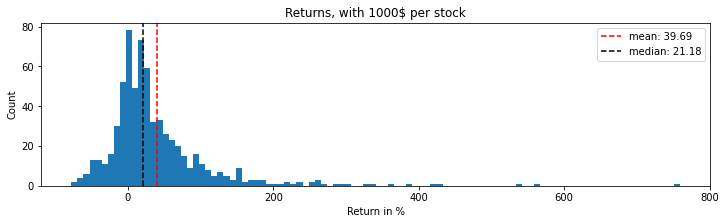

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.hist(returns_perc, bins=100)
ax.set_title(f"Returns, with {CASH_PER_STOCK}$ per stock")
ax.set_ylabel("Count")
ax.set_xlabel("Return in %")
ax.axvline(returns_perc.mean(), color="red", linestyle="--", label=f"mean: {returns_perc.mean():.2f}")
ax.axvline(np.median(returns_perc), color="black", linestyle="--", label=f"median: {np.median(returns_perc):.2f}")
ax.legend();

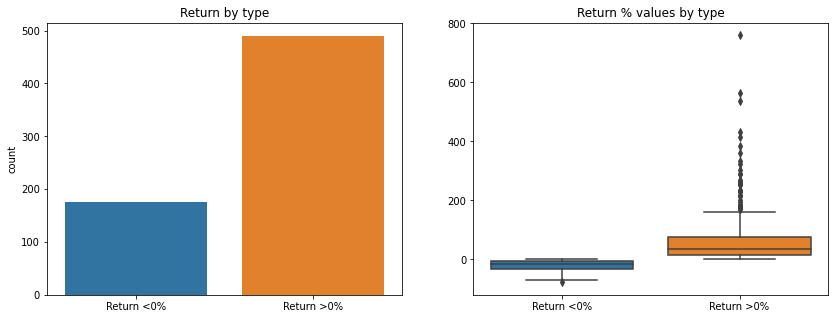

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))

return_types = np.where(returns_perc > 0, 1, 0)
return_type_labels = ["Return <0%", "Return >0%"]

sns.countplot(return_types, ax=ax0)
ax0.set_title("Return by type")
ax0.set_xticklabels(return_type_labels)

sns.boxplot(x=return_types, y=returns_perc, ax=ax1)
ax1.set_title("Return % values by type")
ax1.set_xticklabels(return_type_labels);

## Complete stock list

Usually this is a longer list (~600 rows), which does not really fits in the notebook, so we will create a separate HTML file to store the values

In [20]:
list_html_file_name = "complete_backtest_list.html"

with open(list_html_file_name, "w") as f:
    df_html = results_df.style.background_gradient(cmap="magma_r").render()
    df_html = mmb.paginated_html_table(df_html)
    f.write(df_html)

In [21]:
from IPython.display import HTML, display
display(HTML(filename=list_html_file_name))

,Return [%],Equity Final [$],Equity Peak [$],Buy & Hold Return [%],Start,End,Strategy
Symbol,,,,,,,
MRNA,759.384960,8593.849600,9904.249600,848.674443,2019-12-11 09:00:00-05:00,2021-05-27 19:00:00-04:00,BuyAtFirstMentionAfterShowAndHold
OMI,564.088520,6640.885200,6640.885200,503.718443,2019-12-11 09:30:00-05:00,2021-05-27 19:00:00-04:00,BuyAtFirstMentionAfterShowAndHold
TSLA,536.432760,6364.327600,8995.427600,801.114166,2019-12-11 04:00:00-05:00,2021-05-27 19:00:00-04:00,BuyAtFirstMentionAfterShowAndHold
AMC,430.298880,5302.988800,5530.028800,261.360358,2019-12-12 09:00:00-05:00,2021-05-28 08:00:00-04:00,BuyAtFirstMentionAfterShowAndHold
DOMO,416.286000,5162.860000,5995.120071,168.780488,2019-12-11 09:00:00-05:00,2021-05-27 19:00:00-04:00,BuyAtFirstMentionAfterShowAndHold
IAC,383.170184,4831.701836,6481.701836,241.717838,2019-12-11 09:30:00-05:00,2021-05-27 19:00:00-04:00,BuyAtFirstMentionAfterShowAndHold
NET,360.407300,4604.073000,5227.223000,378.995963,2019-12-11 09:30:00-05:00,2021-05-27 19:00:00-04:00,BuyAtFirstMentionAfterShowAndHold
UPWK,332.566780,4325.667800,5633.337800,352.596479,2019-12-11 09:30:00-05:00,2021-05-27 19:00:00-04:00,BuyAtFirstMentionAfterShowAndHold
SWAV,324.306562,4243.065616,4324.185616,312.470997,2019-12-11 09:30:00-05:00,2021-05-27 19:00:00-04:00,BuyAtFirstMentionAfterShowAndHold


## Individual stock backtesting inspection

If you would like to inspect the backtesting plot of any individual stock, just uncomment the following cells/lines

In [22]:
# symbol_to_inspect = "F"
# df[df["symbol"] == symbol_to_inspect]

In [23]:
# bt_results[symbol_to_inspect]["obj"].plot(resample="D")